[code example](https://www.w3resource.com/python-exercises/advanced/python-bloom-filter-implementation.php)

[how bloom filter works?](https://www.jasondavies.com/bloomfilter/)

In [ ]:
#!pip3 install mmh3

In [4]:
import numpy as np
import pandas as pd
import mmh3
from utils import gen_uniq_seq, gen_grouped_seq

import matplotlib.pyplot as plt

### Task 1

Bloom filter with one hash-function

In [83]:
class BloomFilter_1:
    def __init__(self, n):
        self.n = n
        self.array = np.zeros(self.n, dtype = int)

    def _hash(self, string):
        hash_value = mmh3.hash(string) % self.n
        return hash_value

    def put(self, string):
        index = self._hash(string)
        self.array[index] += 1

    def get(self, string):
        index = self._hash(string)
        return self.array[index] > 0

    def size(self):
        return np.count_nonzero(self.array)


Сгенерируем последовательности для теста.

In [81]:
def generating_sequences(set_sizes):
    for set_size in set_sizes:
        gen_uniq_seq(str(set_size), set_size)

In [82]:
def run_experiments(bf_sizes, set_sizes):
    results = []
    for set_size in set_sizes:
        for bf_size in bf_sizes:
            bf = BloomFilter_1(n = bf_size)
        
            fp_count = 0
            with open(f'{set_size}') as file: 
                for s in file:
                    if bf.get(s):
                        fp_count += 1
                    bf.put(s)
                ones_count = bf.size()

            results.append({'bf_size': bf_size, 
                            'set_size': set_size,
                            'fp_count': fp_count,
                            'ones_count': ones_count})
    
    return results


In [86]:
bf_sizes = [8, 64, 1024, 64000, 16000000]
set_sizes = [5, 50, 500, 5000, 5000000]

results = run_experiments(bf_sizes, set_sizes)

In [98]:
res = pd.DataFrame(results)
res

,bf_size,set_size,fp_count,ones_count
0,8,5,2,3
1,64,5,0,5
2,1024,5,0,5
3,64000,5,0,5
4,16000000,5,0,5
5,8,50,42,8
6,64,50,16,34
7,1024,50,2,48
8,64000,50,0,50
9,16000000,50,0,50


С увеличением размера BF-фильтра относительно размера последовательности снижается число ложноположительных срабатываний.

Делаем вывод о важности корректного выбора размера фильтра относительно поставленной задачи и длины последовательности с целью повышения точности результата.

Ниже представлены графики зависимости числа ложноположительных срабатываний (`fp_count`) от размера фильтра (`bf_size`). Красная граница - длина исследуемой последовательности (`set_size`).

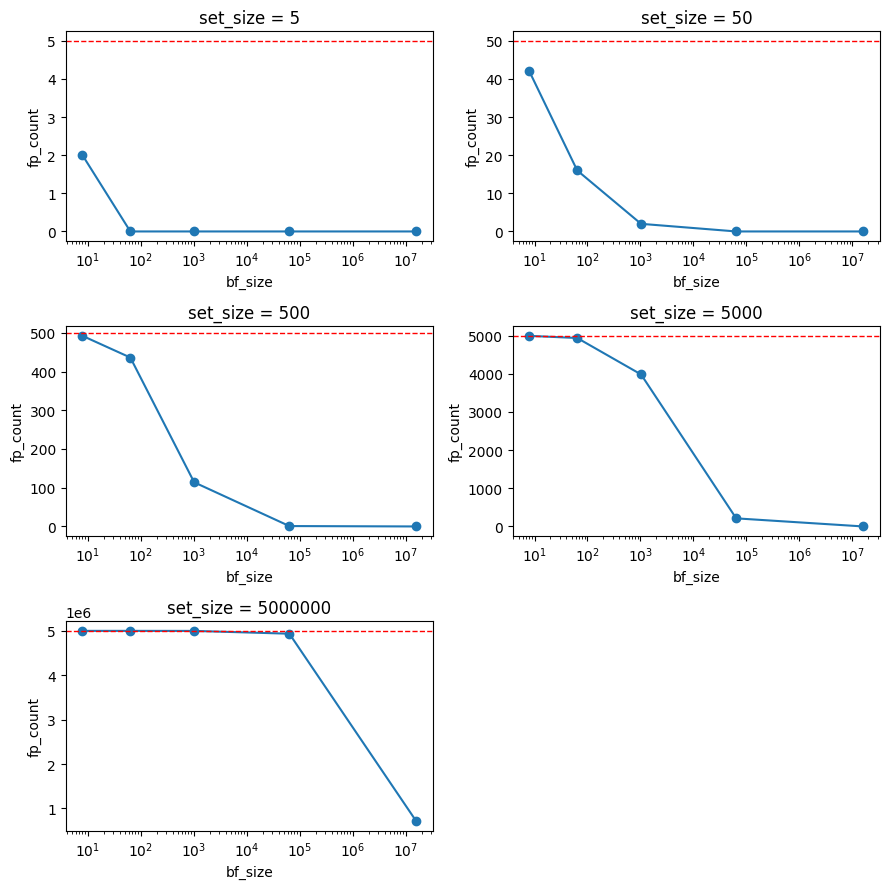

In [129]:
unique_set_sizes = res['set_size'].unique()

# Calculate the number of rows needed for a two-column layout
num_rows = (len(unique_set_sizes) + 1) // 2

# Create the figure and axes
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(9, 3 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through each unique set_size
for i, set_size in enumerate(unique_set_sizes):
    subset = res[res['set_size'] == set_size]
    ax = axes[i]  # Assign the current axis for clarity

    # Plot the data
    ax.plot(subset['bf_size'], subset['fp_count'], marker='o')

    # Set title and labels
    ax.set_title(f'set_size = {set_size}')
    ax.set_xlabel('bf_size')
    ax.set_ylabel('fp_count')

    # Add a horizontal line at y=set_size
    ax.axhline(y=set_size, color='red', linestyle='--', linewidth=1)

    # Set log scale for x-axis
    ax.set_xscale('log')

# Hide any unused axes if the number of plots is odd
if len(unique_set_sizes) % 2 != 0:
    axes[-1].axis('off')

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

### Task 2

Bloom filter on several hash-functions 

In [130]:
class BloomFilter_k:
    def __init__(self, k, n):
        self.k = k
        self.n = n
        self.array = np.zeros(self.n, dtype = int)

    def _hash(self, string):
        hash_value = [mmh3.hash(string, i) % self.n for i in range(self.k)]
        return hash_value

    def put(self, string):
        for hash_value in self._hash(string):
            self.array[hash_value] = True

    def get(self, string):
        return all(self.array[hash_value] for hash_value in self._hash(string))

    def size(self):
        return np.count_nonzero(self.array) / self.k


In [136]:
def run_experiments_2(k, bf_sizes, set_sizes):
    results = []

    for _k in k:
        for set_size in set_sizes:
            for bf_size in bf_sizes:
                bf = BloomFilter_k(k = _k, n = bf_size)
            
                fp_count = 0
                with open(f'{set_size}') as file: 
                    for s in file:
                        if bf.get(s):
                            fp_count += 1
                        bf.put(s)
                    ones_count = bf.size()

                results.append({'k': _k,
                                'bf_size': bf_size, 
                                'set_size': set_size,
                                'fp_count': fp_count,
                                'ones_count': ones_count})
    
    return results

In [143]:
k = [1, 2, 3, 4]
bf_sizes = [8, 64, 1024, 64000, 16000000]
set_sizes = [5, 50, 500, 5000, 5000000]

Посмотрим на экспериментах, как влияет число хэш-функций (`k`) на количество ложных срабатываний.

In [144]:
results = run_experiments_2(k, bf_sizes, set_sizes)

In [146]:
res2 = pd.DataFrame(results)
res2

,k,bf_size,set_size,fp_count,ones_count
0,1,8,5,2,3.00
1,1,64,5,0,5.00
2,1,1024,5,0,5.00
3,1,64000,5,0,5.00
4,1,16000000,5,0,5.00
...,...,...,...,...,...
95,4,8,5000000,4999996,2.00
96,4,64,5000000,4999965,16.00
97,4,1024,5000000,4999459,256.00
98,4,64000,5000000,4966657,16000.00


In [157]:
res2[res2['k'] == 2]

,k,bf_size,set_size,fp_count,ones_count
25,2,8,5,1,2.0
26,2,64,5,0,5.0
27,2,1024,5,0,5.0
28,2,64000,5,0,5.0
29,2,16000000,5,0,5.0
30,2,8,50,43,4.0
31,2,64,50,12,27.0
32,2,1024,50,0,47.5
33,2,64000,50,0,50.0
34,2,16000000,50,0,50.0


Теперь ясно видно так же и то, что необходимо подбирать специфическое число хэш-функций, не забывая и о выборе корректного размера самого фильтра.

Работа нескольких хэш-функций может потребовать больших вычислительных ресурсов, однако повышает точность срабатывания самого фильтра.

Ниже представлены графики зависимости числа ложноположительных срабатываний (`fp_count`) от размера фильтра (`bf_size`) для каждого из числа хэш-функций (`k = [1, 2, 3, 4]`). Красная граница - длина исследуемой последовательности (`set_size`).

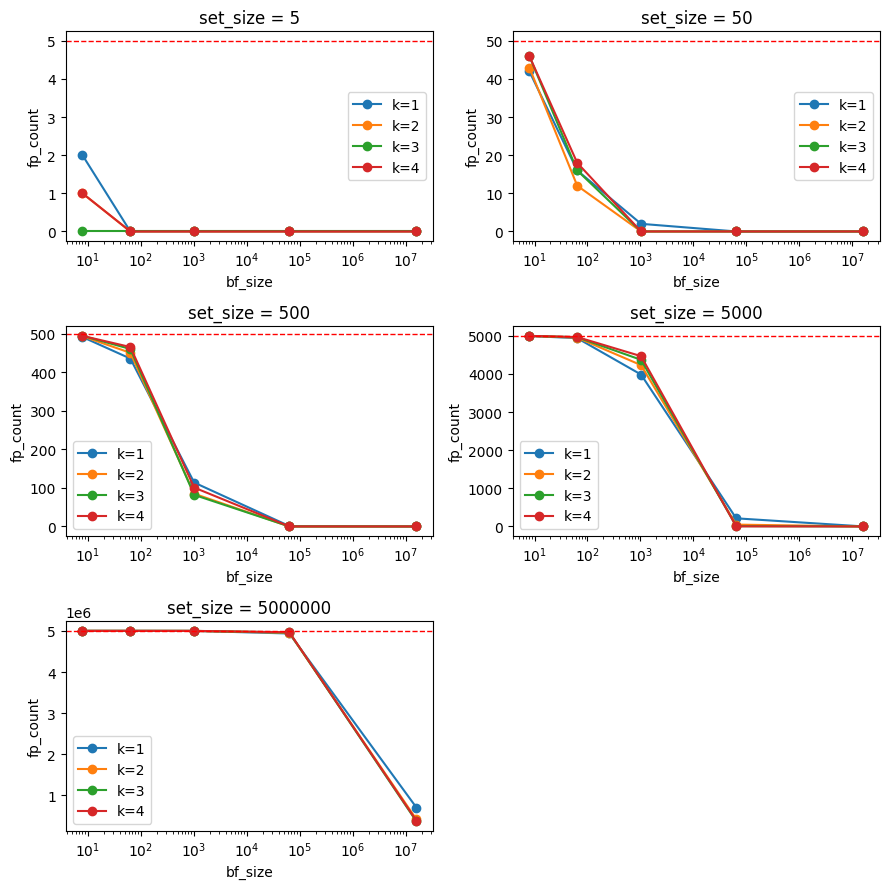

In [156]:
unique_set_sizes = res2['set_size'].unique()

# Calculate the number of rows needed for a two-column layout
num_rows = (len(unique_set_sizes) + 1) // 2

# Create the figure and axes
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(9, 3 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through each unique set_size
for i, set_size in enumerate(unique_set_sizes):
    ax = axes[i]  # Assign the current axis for clarity

    # Filter data for the current set_size
    subset = res2[res2['set_size'] == set_size]

    # Get unique k values for this set_size
    unique_k_values = subset['k'].unique()

    # Plot the data for each unique k value
    for k in unique_k_values:
        k_subset = subset[subset['k'] == k]
        ax.plot(k_subset['bf_size'], k_subset['fp_count'], marker='o', label=f'k={k}')

    # Set title and labels
    ax.set_title(f'set_size = {set_size}')
    ax.set_xlabel('bf_size')
    ax.set_ylabel('fp_count')

    # Add a horizontal line at y=set_size (if needed)
    ax.axhline(y=set_size, color='red', linestyle='--', linewidth=1)

    # Set log scale for x-axis
    ax.set_xscale('log')

    # Add legend for k values
    ax.legend()

# Hide any unused axes if the number of plots is odd
if len(unique_set_sizes) % 2 != 0:
    axes[-1].axis('off')

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()


### Task 3

Counting bloom filter on several hash-functions 

In [20]:
class CountingBloomFilter:
    def __init__(self, n, k, cap): 
        self.n = n
        self.k = k
        self.cap = cap
        self.bits_array = 64 // cap
        self.array_size = (self.n + self.bits_array - 1) // self.bits_array
        self.array = np.zeros(self.array_size, dtype=np.uint64)

    def _hash(self, s, seed):
        hash_value = mmh3.hash(s, seed) % self.n
        return hash_value

    def put(self, s):
        for i in range(self.k): # k - number of hashes
            index = self._hash(s, i)
            counter_index = index // self.bits_array
            bit_position = (index % self.bits_array) * self.cap
            
            current_value = (self.array[counter_index] >> np.uint64(bit_position)) & np.uint64(((1 << self.cap) - 1))
            if current_value < np.uint64((1 << self.cap) - 1):  # max size checking
                current_value += 1
                self.array[counter_index] |= (np.uint64(current_value) << np.uint64(bit_position))


    def get(self, s):
        for i in range(self.k):  # k - number of hashes
            index = self._hash(s, i)
            counter_index = index // self.bits_array
            bit_position = (index % self.bits_array) * self.cap

            if ((self.array[counter_index] >> np.uint64(bit_position)) & np.uint64(((1 << self.cap) - 1))) == 0:
                return False
        return True

    def size(self):
        return sum(bin(counter).count('1') for counter in self.array) / self.k

In [21]:
def run_experiments_3(experiments):
    results = []
    for experiment in experiments:
        cbf = CountingBloomFilter(n = experiment['bf_size'],
                                  k = experiment['k'],
                                  cap = experiment['cap'])
        
        gen_uniq_seq('counting_test', experiment['set_size'])

        fp_count = 0
        with open('counting_test') as file:
            for line in file:
                if cbf.get(line):
                    fp_count += 1
                cbf.put(line)
            ones_count = cbf.size()
        
        results.append({"k": experiment["k"],
                        "bf_size": experiment["bf_size"],
                        "set_size": experiment["set_size"],
                        "cap": experiment["cap"],
                        "fp_count": fp_count,
                        "ones_count": ones_count})

    return results

Проведём ряд экспериментов, проверив, как ведёт себя фильтр при изменении параметров.

Так же рассчитаем оптимальное значение числа хэш-функций (`k`) и проверим, как изменится число ложных срабатываний при изменении числа счётчиков (`cap`).

In [22]:
set_size = 1000000
bf_size = 100000
k_opt = int(set_size / bf_size * np.log(2))

experiments = [{"k": 3, "bf_size": 100, "set_size": 10000, "cap": 4},
               {"k": 5, "bf_size": 1000, "set_size": 10000, "cap": 8},
               {"k": 7, "bf_size": 10000, "set_size": 10000, "cap": 16},
               {"k": 5, "bf_size": 1000, "set_size": 10000, "cap": 8},
               {"k": k_opt, "bf_size": bf_size, "set_size": set_size, "cap": 1},
               {"k": k_opt, "bf_size": bf_size, "set_size": set_size, "cap": 8},
               {"k": k_opt, "bf_size": bf_size, "set_size": set_size, "cap": 16}]

results = run_experiments_3(experiments)

res3 = pd.DataFrame(results)
res3

0
0
0
0
0
0
0


,k,bf_size,set_size,cap,fp_count,ones_count
0,3,100,10000,4,9938,133.333333
1,5,1000,10000,8,9552,1600.000000
2,7,10000,10000,16,6275,9995.714286
3,5,1000,10000,8,9554,1600.000000
4,6,100000,1000000,1,959146,16666.666667
5,6,100000,1000000,8,959177,133333.333333
6,6,100000,1000000,16,959082,266666.666667


### Task 5

Vasya's files problem

Сгенерируем два файла по одинаковому паттерну повторяющихся ключей.

In [7]:
pattern = [(4, 100000), (7, 65000), (12, 40000), (2, 71000), (3, 50000)]

gen_grouped_seq('test1.csv', pattern = pattern, n_extra_cols = 0, to_shuffle = True)
gen_grouped_seq('test2.csv', pattern = pattern, n_extra_cols = 0, to_shuffle = True)

In [11]:
import csv
from collections import defaultdict

KEY_THRESHOLD = 60000

def count_key_occurrences(file_path, key_column=0):
    key_occurrences = defaultdict(int)

    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        for record in csv_reader:
            key = record[key_column]
            key_occurrences[key] += 1

    return key_occurrences

def find_keys_w_problem(counts_file1, counts_file2):
    problematic_keys = set()

    for key, count in counts_file1.items():
        if count > KEY_THRESHOLD or counts_file2.get(key, 0) > KEY_THRESHOLD:
            problematic_keys.add(key)

    for key, count in counts_file2.items():
        if key not in counts_file1 and count > KEY_THRESHOLD:
            problematic_keys.add(key)

    return problematic_keys

def main(file1_path, file2_path):
    counts_file1 = count_key_occurrences(file1_path)
    counts_file2 = count_key_occurrences(file2_path)
    problem_keys = find_keys_w_problem(counts_file1, counts_file2)

    print(f'Число проблемных ключей = {len(problem_keys)}')

Найдём число проблемных ключей и сравним с предсказанием, основанном на сумме количества ключей, по которым превышается пороговое значение (>60000 записей).

In [12]:
main('test1.csv', 'test2.csv')

Число проблемных ключей = 26


In [18]:
predicted_value = 2 * sum(t[0] for t in pattern if t[1] > 60000)
predicted_value

26